In [1]:
!pip install -q flwr[simulation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 28.6 MB/s eta 0:00:00


In [2]:
import flwr as fl
from flwr.common import Metrics
from flwr.common.typing import NDArrays, Scalar
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import os
import librosa

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/daic/ProjectPrototype

/content/gdrive/MyDrive/daic/ProjectPrototype


In [5]:
!ls

'212148conf copy 3.ipynb'   edaicwoz   MFCCs_1030   MFCCs_1030.zip   preprocess_data.ipynb


In [6]:
train_labels_df = pd.read_csv("edaicwoz/train_split.csv")
test_labels_df = pd.read_csv("edaicwoz/test_split.csv")
val_labels_df = pd.read_csv("edaicwoz/dev_split.csv")

In [7]:
def load_audio_files(data_dir, sr=16000):
    file_ids = os.listdir(data_dir)
    subject_ids = []
    file_paths = []
    types = []
    labels = []
    labels_binary = []

    for file_id in file_ids:
        file_id = file_id.split("_")[0]
        file_path = [data_dir + "/" + file_id + "/" + file_id + "_MFCC_" + str(i) + ".npy" for i in range(len(next(iter(enumerate(os.walk(data_dir + "/" + str(file_id) + "/"))))[1][2]))]
        if int(file_id) in train_labels_df["Participant_ID"].values:
            types.append(0)
            labels.append(train_labels_df[train_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(train_labels_df[train_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])

        elif int(file_id) in test_labels_df["Participant_ID"].values:
            types.append(1)
            labels.append(test_labels_df[test_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(test_labels_df[test_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])
        else:
            types.append(2)
            labels.append(val_labels_df[val_labels_df["Participant_ID"] == int(file_id)]['PHQ_Score'].values[0])
            labels_binary.append(val_labels_df[val_labels_df["Participant_ID"] == int(file_id)]['PHQ_Binary'].values[0])
        subject_ids.append(int(file_id))
        file_paths.append(file_path)

    return file_ids, subject_ids, file_paths, types, labels, labels_binary

data_dir = "MFCCs_1030"

file_ids, subject_ids, file_paths, types, labels, labels_binary = load_audio_files(data_dir)

In [8]:
def prepare_audio_set(file_paths):

    samples = []
    samples_ids = []
    samples_types = []
    samples_labels = []
    samples_labels_binary = []

    for i, file_path in enumerate(file_paths):
        all_mfccs = []
        for j in range(len(file_path)):
            all_mfccs.append(np.load(file_path[j]))
        all_mfccs = np.array(all_mfccs)
        samples.extend(all_mfccs)
        samples_ids.extend([subject_ids[i]] * len(all_mfccs))
        samples_types.extend([types[i]] * len(all_mfccs))
        samples_labels.extend([labels[i]] * len(all_mfccs))
        samples_labels_binary.extend([labels_binary[i]] * len(all_mfccs))

    samples = np.array(samples)

    samples_ids = np.array(samples_ids)
    samples_types = np.array(samples_types)
    samples_labels = np.array(samples_labels)
    samples_labels_binary = np.array(samples_labels_binary)

    return samples, samples_ids, samples_types, samples_labels, samples_labels_binary

print("[INFO] preparing data...")
samples, samples_ids, samples_types, samples_labels, samples_labels_binary = prepare_audio_set(file_paths)
samples = np.swapaxes(samples, 1, 2)

[INFO] preparing data...


In [9]:
training_samples = samples[samples_types == 0]
training_labels = samples_labels_binary[samples_types == 0]
training_subject_ids = samples_ids[samples_types == 0]

test_samples = samples[samples_types == 1]
test_labels = samples_labels_binary[samples_types == 1]

val_samples = samples[samples_types == 2]
val_labels_df = samples_labels_binary[samples_types == 2]

In [10]:
del samples, samples_ids, samples_types, samples_labels, samples_labels_binary
del file_ids, subject_ids, file_paths, types, labels, labels_binary

In [11]:
SEED = 42
NUM_CLIENTS = 4
BATCH_SIZE = 32
NUM_ROUNDS = 5
DEPRESSIVE_MULTIPLIER = 30
NON_DEPRESSIVE_MULTIPLIER = 10

In [12]:
def partition_data(X: np.ndarray, X_ids: np.ndarray, n_clients: int, d_mult: int, n_d_mult: int) -> Tuple[List[np.ndarray], List[np.ndarray]]:

    unique_subject_ids, counts = np.unique(X_ids, return_counts=True)

    # grouping the training samples by patient
    training_samples_grouped = []
    for i in unique_subject_ids:
        training_samples_grouped.append(X[X_ids == i])
    training_samples_grouped = np.array(training_samples_grouped)

    mask_30_segments = np.array([sample.shape[0] == DEPRESSIVE_MULTIPLIER for sample in training_samples_grouped])

    # creating masks to get deppressives and non deppressives
    mask_10_segments = np.array([sample.shape[0] == NON_DEPRESSIVE_MULTIPLIER for sample in training_samples_grouped])

    data_array_30_segments = training_samples_grouped[mask_30_segments]

    data_array_10_segments = training_samples_grouped[mask_10_segments]

    # recreating labels
    X_train_zeros = np.array_split(data_array_10_segments, NUM_CLIENTS)
    X_train_ones = np.array_split(data_array_30_segments, NUM_CLIENTS)

    # concatenating splitted ones and zeros with labels
    X_train_splitted = [] # (NUM_CLIENTS, data)
    y_train_splitted = [] # (NUM_CLIENTS, labels)
    for i in range(NUM_CLIENTS):

        # stack the segments from groups then concatenate
        client_data = np.concatenate((np.vstack(X_train_zeros[i]), np.vstack(X_train_ones[i])), axis=0)
        client_labels = np.concatenate((np.zeros((X_train_zeros[i].shape[0] * NON_DEPRESSIVE_MULTIPLIER), dtype=int), np.ones((X_train_ones[i].shape[0] * DEPRESSIVE_MULTIPLIER), dtype=int)), axis=0)

        X_train_splitted.append(client_data)
        y_train_splitted.append(client_labels)

    return X_train_splitted, y_train_splitted

X_trains, y_trains = partition_data(training_samples, training_subject_ids, NUM_CLIENTS, DEPRESSIVE_MULTIPLIER, NON_DEPRESSIVE_MULTIPLIER)

<ipython-input-12-45e26c792d34>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_samples_grouped = np.array(training_samples_grouped)


In [13]:
del training_samples, training_labels, training_subject_ids

In [ ]:
X_trains[0].shape

(610, 15001, 13)

In [14]:
def get_model(input_shape):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.GRU(units = 64, input_shape = input_shape)) 

    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

In [18]:
from flwr.common.typing import NDArrays
class FlowerClient(fl.client.NumPyClient):

    def __init__(self, model: tf.keras.models.Sequential, X_train: np.ndarray, y_train: np.ndarray):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train

    def get_parameters(self, config):
        return self.model.get_weights()


    def fit(self, parameters: NDArrays, config: Dict[str, Scalar]) -> NDArrays:
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

        self.model.set_weights(parameters)

        history = self.model.fit(self.X_train, self.y_train ,batch_size=BATCH_SIZE, epochs=1, verbose=0)
        results = {
            "loss": history.history["loss"][0],
            "accuracy": history.history["accuracy"][0],
        }
        return self.model.get_weights(), len(self.X_train), results

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar])-> Tuple[float, int, Dict[str, Scalar]]:
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])
        self.model.set_weights(parameters)

        loss, acc = self.model.evaluate(self.X_train, self.y_train, verbose=0)
        return loss, len(self.X_train), {"accuracy": acc}

In [19]:
# client creator by client id
def create_client_fn(cid: str) -> FlowerClient:

    input_shape = (15001, 13)
    model = get_model(input_shape)
    cid_int = int(cid)
    return FlowerClient(model, X_trains[cid_int], y_trains[cid_int])

In [20]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [27]:
patience = 5
best_accuracy = 0.0
best_loss = 999
weights = np.array([])
def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
    ) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    """Centralized evaluation function"""

    input_shape = (15001, 13)
    model = get_model(input_shape)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

    model.set_weights(parameters)

    loss, accuracy = model.evaluate(val_samples, val_labels_df, batch_size=16, verbose=0)

    global best_accuracy
    global best_loss
    global weights
    
    print(f"LOSS: {loss}")
    print(f"BEST_LOSS: {best_loss}")
    print(f"ACCURACY: {accuracy}")
    print(f"BEST_ACCURACY: {best_accuracy}")

    if loss < best_loss:
        best_accuracy = accuracy
        weights = parameters
        best_loss = loss

    return loss, {"accuracy": accuracy}



client_resources = {"num_cpus": 2}
if tf.config.get_visible_devices("GPU"):
    client_resources["num_gpus"] = 1

# Specify the Strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1.0, 
    min_fit_clients=NUM_CLIENTS, 
    min_evaluate_clients=NUM_CLIENTS, 
    min_available_clients=NUM_CLIENTS,  # Wait until all 4 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=evaluate
)

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=create_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=25),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-12-11 10:41:35,057 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=25, round_timeout=None)
2023-12-11 10:41:39,440	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-11 10:41:40,956 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 8.0, 'accelerator_type:V100': 1.0, 'memory': 32521003008.0, 'object_store_memory': 16260501504.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 8.0, 'accelerator_type:V100': 1.0, 'memory': 32521003008.0, 'object_store_memory': 16260501504.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO flwr 2023-12-11 10:41:40,959 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower V

LOSS: 0.7719388008117676
BEST_LOSS: 999
ACCURACY: 0.45500001311302185
BEST_ACCURACY: 0.0


DEBUG flwr 2023-12-11 10:43:15,324 | server.py:236 | fit_round 1 received 4 results and 0 failures
DEBUG:flwr:fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-12-11 10:43:15,335 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-12-11 10:43:24,081 | server.py:125 | fit progress: (1, 0.6810452938079834, {'accuracy': 0.5737500190734863}, 84.9012222299998)
INFO:flwr:fit progress: (1, 0.6810452938079834, {'accuracy': 0.5737500190734863}, 84.9012222299998)
DEBUG flwr 2023-12-11 10:43:24,083 | server.py:173 | evaluate_round 1: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 1: strategy sampled 4 clients (out of 4)


LOSS: 0.6810452938079834
BEST_LOSS: 0.7719388008117676
ACCURACY: 0.5737500190734863
BEST_ACCURACY: 0.45500001311302185


DEBUG flwr 2023-12-11 10:44:15,130 | server.py:187 | evaluate_round 1 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 4 results and 0 failures
DEBUG flwr 2023-12-11 10:44:15,133 | server.py:222 | fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 2: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 10:45:26,862 | server.py:236 | fit_round 2 received 4 results and 0 failures
DEBUG:flwr:fit_round 2 received 4 results and 0 failures
INFO flwr 2023-12-11 10:45:35,565 | server.py:125 | fit progress: (2, 0.679108202457428, {'accuracy': 0.5724999904632568}, 216.38547342199945)
INFO:flwr:fit progress: (2, 0.679108202457428, {'accuracy': 0.5724999904632568}, 216.38547342199945)
DEBUG flwr 2023-12-11 10:45:35,567 | server.py:173 | evaluate_round 2: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 2: strategy sampled 4 clients (out of 4)


LOSS: 0.679108202457428
BEST_LOSS: 0.6810452938079834
ACCURACY: 0.5724999904632568
BEST_ACCURACY: 0.5737500190734863


DEBUG flwr 2023-12-11 10:46:25,668 | server.py:187 | evaluate_round 2 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-12-11 10:46:25,672 | server.py:222 | fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 3: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 10:47:35,366 | server.py:236 | fit_round 3 received 4 results and 0 failures
DEBUG:flwr:fit_round 3 received 4 results and 0 failures
INFO flwr 2023-12-11 10:47:43,906 | server.py:125 | fit progress: (3, 0.6761940121650696, {'accuracy': 0.5837500095367432}, 344.7268479229997)
INFO:flwr:fit progress: (3, 0.6761940121650696, {'accuracy': 0.5837500095367432}, 344.7268479229997)
DEBUG flwr 2023-12-11 10:47:43,910 | server.py:173 | evaluate_round 3: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 3: strategy sampled 4 clients (out of 4)


LOSS: 0.6761940121650696
BEST_LOSS: 0.679108202457428
ACCURACY: 0.5837500095367432
BEST_ACCURACY: 0.5724999904632568


DEBUG flwr 2023-12-11 10:48:34,442 | server.py:187 | evaluate_round 3 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-12-11 10:48:34,445 | server.py:222 | fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 4: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 10:49:43,989 | server.py:236 | fit_round 4 received 4 results and 0 failures
DEBUG:flwr:fit_round 4 received 4 results and 0 failures
INFO flwr 2023-12-11 10:49:52,711 | server.py:125 | fit progress: (4, 0.6755344867706299, {'accuracy': 0.5774999856948853}, 473.5311966479994)
INFO:flwr:fit progress: (4, 0.6755344867706299, {'accuracy': 0.5774999856948853}, 473.5311966479994)
DEBUG flwr 2023-12-11 10:49:52,715 | server.py:173 | evaluate_round 4: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 4: strategy sampled 4 clients (out of 4)


LOSS: 0.6755344867706299
BEST_LOSS: 0.6761940121650696
ACCURACY: 0.5774999856948853
BEST_ACCURACY: 0.5837500095367432


DEBUG flwr 2023-12-11 10:50:43,175 | server.py:187 | evaluate_round 4 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-12-11 10:50:43,178 | server.py:222 | fit_round 5: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 5: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 10:51:54,074 | server.py:236 | fit_round 5 received 4 results and 0 failures
DEBUG:flwr:fit_round 5 received 4 results and 0 failures
INFO flwr 2023-12-11 10:52:02,711 | server.py:125 | fit progress: (5, 0.6690609455108643, {'accuracy': 0.6200000047683716}, 603.5319713849995)
INFO:flwr:fit progress: (5, 0.6690609455108643, {'accuracy': 0.6200000047683716}, 603.5319713849995)
DEBUG flwr 2023-12-11 10:52:02,714 | server.py:173 | evaluate_round 5: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 5: strategy sampled 4 clients (out of 4)


LOSS: 0.6690609455108643
BEST_LOSS: 0.6755344867706299
ACCURACY: 0.6200000047683716
BEST_ACCURACY: 0.5774999856948853


DEBUG flwr 2023-12-11 10:52:51,741 | server.py:187 | evaluate_round 5 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 4 results and 0 failures
DEBUG flwr 2023-12-11 10:52:51,743 | server.py:222 | fit_round 6: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 6: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 10:54:03,135 | server.py:236 | fit_round 6 received 4 results and 0 failures
DEBUG:flwr:fit_round 6 received 4 results and 0 failures
INFO flwr 2023-12-11 10:54:11,669 | server.py:125 | fit progress: (6, 0.6669384837150574, {'accuracy': 0.6137499809265137}, 732.4893105379997)
INFO:flwr:fit progress: (6, 0.6669384837150574, {'accuracy': 0.6137499809265137}, 732.4893105379997)
DEBUG flwr 2023-12-11 10:54:11,671 | server.py:173 | evaluate_round 6: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 6: strategy sampled 4 clients (out of 4)


LOSS: 0.6669384837150574
BEST_LOSS: 0.6690609455108643
ACCURACY: 0.6137499809265137
BEST_ACCURACY: 0.6200000047683716


DEBUG flwr 2023-12-11 10:55:01,775 | server.py:187 | evaluate_round 6 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 4 results and 0 failures
DEBUG flwr 2023-12-11 10:55:01,779 | server.py:222 | fit_round 7: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 7: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 10:56:12,029 | server.py:236 | fit_round 7 received 4 results and 0 failures
DEBUG:flwr:fit_round 7 received 4 results and 0 failures
INFO flwr 2023-12-11 10:56:20,684 | server.py:125 | fit progress: (7, 0.6650485396385193, {'accuracy': 0.581250011920929}, 861.5050354979994)
INFO:flwr:fit progress: (7, 0.6650485396385193, {'accuracy': 0.581250011920929}, 861.5050354979994)
DEBUG flwr 2023-12-11 10:56:20,687 | server.py:173 | evaluate_round 7: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 7: strategy sampled 4 clients (out of 4)


LOSS: 0.6650485396385193
BEST_LOSS: 0.6669384837150574
ACCURACY: 0.581250011920929
BEST_ACCURACY: 0.6137499809265137


DEBUG flwr 2023-12-11 10:57:11,480 | server.py:187 | evaluate_round 7 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 4 results and 0 failures
DEBUG flwr 2023-12-11 10:57:11,485 | server.py:222 | fit_round 8: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 8: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 10:58:21,856 | server.py:236 | fit_round 8 received 4 results and 0 failures
DEBUG:flwr:fit_round 8 received 4 results and 0 failures
INFO flwr 2023-12-11 10:58:30,620 | server.py:125 | fit progress: (8, 0.664384663105011, {'accuracy': 0.606249988079071}, 991.440317218)
INFO:flwr:fit progress: (8, 0.664384663105011, {'accuracy': 0.606249988079071}, 991.440317218)
DEBUG flwr 2023-12-11 10:58:30,622 | server.py:173 | evaluate_round 8: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 8: strategy sampled 4 clients (out of 4)


LOSS: 0.664384663105011
BEST_LOSS: 0.6650485396385193
ACCURACY: 0.606249988079071
BEST_ACCURACY: 0.581250011920929


DEBUG flwr 2023-12-11 10:59:22,057 | server.py:187 | evaluate_round 8 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 4 results and 0 failures
DEBUG flwr 2023-12-11 10:59:22,061 | server.py:222 | fit_round 9: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 9: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:00:32,140 | server.py:236 | fit_round 9 received 4 results and 0 failures
DEBUG:flwr:fit_round 9 received 4 results and 0 failures
INFO flwr 2023-12-11 11:00:40,802 | server.py:125 | fit progress: (9, 0.6671249270439148, {'accuracy': 0.6012499928474426}, 1121.6225500789997)
INFO:flwr:fit progress: (9, 0.6671249270439148, {'accuracy': 0.6012499928474426}, 1121.6225500789997)
DEBUG flwr 2023-12-11 11:00:40,805 | server.py:173 | evaluate_round 9: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 9: strategy sampled 4 clients (out of 4)


LOSS: 0.6671249270439148
BEST_LOSS: 0.664384663105011
ACCURACY: 0.6012499928474426
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:01:31,996 | server.py:187 | evaluate_round 9 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:01:32,001 | server.py:222 | fit_round 10: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 10: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:02:43,945 | server.py:236 | fit_round 10 received 4 results and 0 failures
DEBUG:flwr:fit_round 10 received 4 results and 0 failures
INFO flwr 2023-12-11 11:02:52,625 | server.py:125 | fit progress: (10, 0.6702646017074585, {'accuracy': 0.6100000143051147}, 1253.4456602949995)
INFO:flwr:fit progress: (10, 0.6702646017074585, {'accuracy': 0.6100000143051147}, 1253.4456602949995)
DEBUG flwr 2023-12-11 11:02:52,627 | server.py:173 | evaluate_round 10: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 10: strategy sampled 4 clients (out of 4)


LOSS: 0.6702646017074585
BEST_LOSS: 0.664384663105011
ACCURACY: 0.6100000143051147
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:03:41,814 | server.py:187 | evaluate_round 10 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:03:41,816 | server.py:222 | fit_round 11: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 11: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:04:54,043 | server.py:236 | fit_round 11 received 4 results and 0 failures
DEBUG:flwr:fit_round 11 received 4 results and 0 failures
INFO flwr 2023-12-11 11:05:02,686 | server.py:125 | fit progress: (11, 0.6742975115776062, {'accuracy': 0.5899999737739563}, 1383.5062351799997)
INFO:flwr:fit progress: (11, 0.6742975115776062, {'accuracy': 0.5899999737739563}, 1383.5062351799997)
DEBUG flwr 2023-12-11 11:05:02,688 | server.py:173 | evaluate_round 11: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 11: strategy sampled 4 clients (out of 4)


LOSS: 0.6742975115776062
BEST_LOSS: 0.664384663105011
ACCURACY: 0.5899999737739563
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:05:53,339 | server.py:187 | evaluate_round 11 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:05:53,344 | server.py:222 | fit_round 12: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 12: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:07:03,390 | server.py:236 | fit_round 12 received 4 results and 0 failures
DEBUG:flwr:fit_round 12 received 4 results and 0 failures
INFO flwr 2023-12-11 11:07:12,023 | server.py:125 | fit progress: (12, 0.6758741736412048, {'accuracy': 0.606249988079071}, 1512.8432943110001)
INFO:flwr:fit progress: (12, 0.6758741736412048, {'accuracy': 0.606249988079071}, 1512.8432943110001)
DEBUG flwr 2023-12-11 11:07:12,025 | server.py:173 | evaluate_round 12: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 12: strategy sampled 4 clients (out of 4)


LOSS: 0.6758741736412048
BEST_LOSS: 0.664384663105011
ACCURACY: 0.606249988079071
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:08:03,368 | server.py:187 | evaluate_round 12 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:08:03,371 | server.py:222 | fit_round 13: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 13: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:09:13,748 | server.py:236 | fit_round 13 received 4 results and 0 failures
DEBUG:flwr:fit_round 13 received 4 results and 0 failures
INFO flwr 2023-12-11 11:09:22,448 | server.py:125 | fit progress: (13, 0.682945728302002, {'accuracy': 0.606249988079071}, 1643.2685305269997)
INFO:flwr:fit progress: (13, 0.682945728302002, {'accuracy': 0.606249988079071}, 1643.2685305269997)
DEBUG flwr 2023-12-11 11:09:22,452 | server.py:173 | evaluate_round 13: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 13: strategy sampled 4 clients (out of 4)


LOSS: 0.682945728302002
BEST_LOSS: 0.664384663105011
ACCURACY: 0.606249988079071
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:10:13,900 | server.py:187 | evaluate_round 13 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:10:13,904 | server.py:222 | fit_round 14: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 14: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:11:24,250 | server.py:236 | fit_round 14 received 4 results and 0 failures
DEBUG:flwr:fit_round 14 received 4 results and 0 failures
INFO flwr 2023-12-11 11:11:33,028 | server.py:125 | fit progress: (14, 0.6949994564056396, {'accuracy': 0.5975000262260437}, 1773.849005305)
INFO:flwr:fit progress: (14, 0.6949994564056396, {'accuracy': 0.5975000262260437}, 1773.849005305)
DEBUG flwr 2023-12-11 11:11:33,031 | server.py:173 | evaluate_round 14: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 14: strategy sampled 4 clients (out of 4)


LOSS: 0.6949994564056396
BEST_LOSS: 0.664384663105011
ACCURACY: 0.5975000262260437
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:12:24,720 | server.py:187 | evaluate_round 14 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:12:24,723 | server.py:222 | fit_round 15: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 15: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:13:37,384 | server.py:236 | fit_round 15 received 4 results and 0 failures
DEBUG:flwr:fit_round 15 received 4 results and 0 failures
INFO flwr 2023-12-11 11:13:46,141 | server.py:125 | fit progress: (15, 0.70476233959198, {'accuracy': 0.6012499928474426}, 1906.9613990459993)
INFO:flwr:fit progress: (15, 0.70476233959198, {'accuracy': 0.6012499928474426}, 1906.9613990459993)
DEBUG flwr 2023-12-11 11:13:46,143 | server.py:173 | evaluate_round 15: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 15: strategy sampled 4 clients (out of 4)


LOSS: 0.70476233959198
BEST_LOSS: 0.664384663105011
ACCURACY: 0.6012499928474426
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:14:35,527 | server.py:187 | evaluate_round 15 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:14:35,530 | server.py:222 | fit_round 16: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 16: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:15:48,459 | server.py:236 | fit_round 16 received 4 results and 0 failures
DEBUG:flwr:fit_round 16 received 4 results and 0 failures
INFO flwr 2023-12-11 11:15:57,226 | server.py:125 | fit progress: (16, 0.722639262676239, {'accuracy': 0.5899999737739563}, 2038.0468328099996)
INFO:flwr:fit progress: (16, 0.722639262676239, {'accuracy': 0.5899999737739563}, 2038.0468328099996)
DEBUG flwr 2023-12-11 11:15:57,229 | server.py:173 | evaluate_round 16: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 16: strategy sampled 4 clients (out of 4)


LOSS: 0.722639262676239
BEST_LOSS: 0.664384663105011
ACCURACY: 0.5899999737739563
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:16:48,769 | server.py:187 | evaluate_round 16 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:16:48,771 | server.py:222 | fit_round 17: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 17: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:18:00,449 | server.py:236 | fit_round 17 received 4 results and 0 failures
DEBUG:flwr:fit_round 17 received 4 results and 0 failures
INFO flwr 2023-12-11 11:18:09,276 | server.py:125 | fit progress: (17, 0.7247633337974548, {'accuracy': 0.5862500071525574}, 2170.0966159439995)
INFO:flwr:fit progress: (17, 0.7247633337974548, {'accuracy': 0.5862500071525574}, 2170.0966159439995)
DEBUG flwr 2023-12-11 11:18:09,278 | server.py:173 | evaluate_round 17: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 17: strategy sampled 4 clients (out of 4)


LOSS: 0.7247633337974548
BEST_LOSS: 0.664384663105011
ACCURACY: 0.5862500071525574
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:19:01,347 | server.py:187 | evaluate_round 17 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:19:01,352 | server.py:222 | fit_round 18: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 18: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:20:12,125 | server.py:236 | fit_round 18 received 4 results and 0 failures
DEBUG:flwr:fit_round 18 received 4 results and 0 failures
INFO flwr 2023-12-11 11:20:20,977 | server.py:125 | fit progress: (18, 0.7382436394691467, {'accuracy': 0.5762500166893005}, 2301.7973967849994)
INFO:flwr:fit progress: (18, 0.7382436394691467, {'accuracy': 0.5762500166893005}, 2301.7973967849994)
DEBUG flwr 2023-12-11 11:20:20,979 | server.py:173 | evaluate_round 18: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 18: strategy sampled 4 clients (out of 4)


LOSS: 0.7382436394691467
BEST_LOSS: 0.664384663105011
ACCURACY: 0.5762500166893005
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:21:13,036 | server.py:187 | evaluate_round 18 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:21:13,040 | server.py:222 | fit_round 19: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 19: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:22:22,353 | server.py:236 | fit_round 19 received 4 results and 0 failures
DEBUG:flwr:fit_round 19 received 4 results and 0 failures
INFO flwr 2023-12-11 11:22:30,882 | server.py:125 | fit progress: (19, 0.7559373378753662, {'accuracy': 0.5799999833106995}, 2431.7027453249993)
INFO:flwr:fit progress: (19, 0.7559373378753662, {'accuracy': 0.5799999833106995}, 2431.7027453249993)
DEBUG flwr 2023-12-11 11:22:30,885 | server.py:173 | evaluate_round 19: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 19: strategy sampled 4 clients (out of 4)


LOSS: 0.7559373378753662
BEST_LOSS: 0.664384663105011
ACCURACY: 0.5799999833106995
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:23:22,920 | server.py:187 | evaluate_round 19 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:23:22,922 | server.py:222 | fit_round 20: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 20: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:24:35,840 | server.py:236 | fit_round 20 received 4 results and 0 failures
DEBUG:flwr:fit_round 20 received 4 results and 0 failures
INFO flwr 2023-12-11 11:24:44,506 | server.py:125 | fit progress: (20, 0.7718173265457153, {'accuracy': 0.5737500190734863}, 2565.3269001139997)
INFO:flwr:fit progress: (20, 0.7718173265457153, {'accuracy': 0.5737500190734863}, 2565.3269001139997)
DEBUG flwr 2023-12-11 11:24:44,508 | server.py:173 | evaluate_round 20: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 20: strategy sampled 4 clients (out of 4)


LOSS: 0.7718173265457153
BEST_LOSS: 0.664384663105011
ACCURACY: 0.5737500190734863
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:25:33,727 | server.py:187 | evaluate_round 20 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:25:33,730 | server.py:222 | fit_round 21: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 21: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:26:47,173 | server.py:236 | fit_round 21 received 4 results and 0 failures
DEBUG:flwr:fit_round 21 received 4 results and 0 failures
INFO flwr 2023-12-11 11:26:55,752 | server.py:125 | fit progress: (21, 0.7841352820396423, {'accuracy': 0.5712500214576721}, 2696.5727751569993)
INFO:flwr:fit progress: (21, 0.7841352820396423, {'accuracy': 0.5712500214576721}, 2696.5727751569993)
DEBUG flwr 2023-12-11 11:26:55,754 | server.py:173 | evaluate_round 21: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 21: strategy sampled 4 clients (out of 4)


LOSS: 0.7841352820396423
BEST_LOSS: 0.664384663105011
ACCURACY: 0.5712500214576721
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:27:46,768 | server.py:187 | evaluate_round 21 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:27:46,770 | server.py:222 | fit_round 22: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 22: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:28:57,204 | server.py:236 | fit_round 22 received 4 results and 0 failures
DEBUG:flwr:fit_round 22 received 4 results and 0 failures
INFO flwr 2023-12-11 11:29:05,753 | server.py:125 | fit progress: (22, 0.7952831387519836, {'accuracy': 0.5724999904632568}, 2826.573152729)
INFO:flwr:fit progress: (22, 0.7952831387519836, {'accuracy': 0.5724999904632568}, 2826.573152729)
DEBUG flwr 2023-12-11 11:29:05,755 | server.py:173 | evaluate_round 22: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 22: strategy sampled 4 clients (out of 4)


LOSS: 0.7952831387519836
BEST_LOSS: 0.664384663105011
ACCURACY: 0.5724999904632568
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:29:57,265 | server.py:187 | evaluate_round 22 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:29:57,272 | server.py:222 | fit_round 23: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 23: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:31:07,081 | server.py:236 | fit_round 23 received 4 results and 0 failures
DEBUG:flwr:fit_round 23 received 4 results and 0 failures
INFO flwr 2023-12-11 11:31:15,770 | server.py:125 | fit progress: (23, 0.8037551641464233, {'accuracy': 0.581250011920929}, 2956.591033776999)
INFO:flwr:fit progress: (23, 0.8037551641464233, {'accuracy': 0.581250011920929}, 2956.591033776999)
DEBUG flwr 2023-12-11 11:31:15,773 | server.py:173 | evaluate_round 23: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 23: strategy sampled 4 clients (out of 4)


LOSS: 0.8037551641464233
BEST_LOSS: 0.664384663105011
ACCURACY: 0.581250011920929
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:32:07,581 | server.py:187 | evaluate_round 23 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:32:07,591 | server.py:222 | fit_round 24: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 24: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:33:17,485 | server.py:236 | fit_round 24 received 4 results and 0 failures
DEBUG:flwr:fit_round 24 received 4 results and 0 failures
INFO flwr 2023-12-11 11:33:26,092 | server.py:125 | fit progress: (24, 0.802239179611206, {'accuracy': 0.5849999785423279}, 3086.9127907150005)
INFO:flwr:fit progress: (24, 0.802239179611206, {'accuracy': 0.5849999785423279}, 3086.9127907150005)
DEBUG flwr 2023-12-11 11:33:26,094 | server.py:173 | evaluate_round 24: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 24: strategy sampled 4 clients (out of 4)


LOSS: 0.802239179611206
BEST_LOSS: 0.664384663105011
ACCURACY: 0.5849999785423279
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:34:18,146 | server.py:187 | evaluate_round 24 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 4 results and 0 failures
DEBUG flwr 2023-12-11 11:34:18,154 | server.py:222 | fit_round 25: strategy sampled 4 clients (out of 4)
DEBUG:flwr:fit_round 25: strategy sampled 4 clients (out of 4)
DEBUG flwr 2023-12-11 11:35:31,304 | server.py:236 | fit_round 25 received 4 results and 0 failures
DEBUG:flwr:fit_round 25 received 4 results and 0 failures
INFO flwr 2023-12-11 11:35:39,871 | server.py:125 | fit progress: (25, 0.8071300387382507, {'accuracy': 0.5774999856948853}, 3220.6914203959996)
INFO:flwr:fit progress: (25, 0.8071300387382507, {'accuracy': 0.5774999856948853}, 3220.6914203959996)
DEBUG flwr 2023-12-11 11:35:39,873 | server.py:173 | evaluate_round 25: strategy sampled 4 clients (out of 4)
DEBUG:flwr:evaluate_round 25: strategy sampled 4 clients (out of 4)


LOSS: 0.8071300387382507
BEST_LOSS: 0.664384663105011
ACCURACY: 0.5774999856948853
BEST_ACCURACY: 0.606249988079071


DEBUG flwr 2023-12-11 11:36:29,042 | server.py:187 | evaluate_round 25 received 4 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 4 results and 0 failures
INFO flwr 2023-12-11 11:36:29,044 | server.py:153 | FL finished in 3269.8649426519996
INFO:flwr:FL finished in 3269.8649426519996
INFO flwr 2023-12-11 11:36:29,046 | app.py:226 | app_fit: losses_distributed [(1, 0.683141635326629), (2, 0.6696657989887481), (3, 0.6598204610195566), (4, 0.6504833825091099), (5, 0.6414851876015358), (6, 0.6295759459759327), (7, 0.6158229614825959), (8, 0.6060631810350621), (9, 0.5957427681760585), (10, 0.5860120172196246), (11, 0.5777181059756178), (12, 0.5718287726666065), (13, 0.5674677529233567), (14, 0.5557119278197593), (15, 0.5494240418393561), (16, 0.5501413669992), (17, 0.5374023777373294), (18, 0.5264038091010236), (19, 0.5228546698042686), (20, 0.5166430473327637), (21, 0.5075230469094946), (22, 0.5027921532062773), (23, 0.5019869921055246), (24, 0.4931996284647191), (25, 0.480934

In [28]:
history

History (loss, distributed):
	round 1: 0.683141635326629
	round 2: 0.6696657989887481
	round 3: 0.6598204610195566
	round 4: 0.6504833825091099
	round 5: 0.6414851876015358
	round 6: 0.6295759459759327
	round 7: 0.6158229614825959
	round 8: 0.6060631810350621
	round 9: 0.5957427681760585
	round 10: 0.5860120172196246
	round 11: 0.5777181059756178
	round 12: 0.5718287726666065
	round 13: 0.5674677529233567
	round 14: 0.5557119278197593
	round 15: 0.5494240418393561
	round 16: 0.5501413669992
	round 17: 0.5374023777373294
	round 18: 0.5264038091010236
	round 19: 0.5228546698042686
	round 20: 0.5166430473327637
	round 21: 0.5075230469094946
	round 22: 0.5027921532062773
	round 23: 0.5019869921055246
	round 24: 0.4931996284647191
	round 25: 0.4809347528092405
History (loss, centralized):
	round 0: 0.7719388008117676
	round 1: 0.6810452938079834
	round 2: 0.679108202457428
	round 3: 0.6761940121650696
	round 4: 0.6755344867706299
	round 5: 0.6690609455108643
	round 6: 0.6669384837150574
	ro

In [29]:
# printing the validation results
print(best_accuracy)
print(best_loss)
print(patience)
print(weights)

0.606249988079071
0.664384663105011
5
[array([[-0.06994066,  0.05564391,  0.00976616, ...,  0.11722373,
        -0.13458657, -0.16258053],
       [ 0.03089281, -0.1371244 , -0.10657254, ...,  0.14988244,
        -0.08280139,  0.00337988],
       [ 0.06557301, -0.12406567,  0.02839158, ..., -0.02232929,
        -0.10008051,  0.09818005],
       ...,
       [ 0.10380115, -0.09644467, -0.0252454 , ...,  0.12678124,
        -0.16799314, -0.18072154],
       [ 0.12014075,  0.1705786 ,  0.05098794, ...,  0.13406095,
        -0.15388075, -0.06678468],
       [-0.06118714, -0.08014546, -0.00699787, ...,  0.13966732,
        -0.07440311,  0.11775417]], dtype=float32), array([[-0.00974427, -0.00937715,  0.08989271, ..., -0.01705151,
        -0.00616625,  0.01163915],
       [-0.11839157,  0.09261702, -0.02385725, ...,  0.02739944,
        -0.0188187 ,  0.04025863],
       [ 0.0023925 , -0.06585002,  0.04161897, ...,  0.04701117,
         0.06881989, -0.05447621],
       ...,
       [ 0.00097213,

In [30]:
# testing the model
input_shape = (15001, 13)
test_model = get_model(input_shape)
test_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

test_model.set_weights(weights)

print("[INFO] evaluating on testing set...")
(test_loss, test_accuracy) = test_model.evaluate(test_samples, test_labels, batch_size=8, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(test_loss, test_accuracy * 100))

[INFO] evaluating on testing set...
70/70 [==============================] - 10s 129ms/step - loss: 0.6595 - accuracy: 0.6482
[INFO] loss=0.6595, accuracy: 64.8214%


In [31]:
from tqdm import tqdm

test_preds = []

file_ids = os.listdir(data_dir)

test_label_file = pd.read_csv("edaicwoz/test_split.csv")

for file_id in tqdm(file_ids):
    if int(file_id) in test_label_file["Participant_ID"].values:
        all_mfccs = []
        for j in range(10):
            file_path = "MFCCs_1030/" + file_id + "/" + file_id + "_MFCC_" + str(j) + ".npy"
            all_mfccs.append(np.load(file_path))
        all_mfccs = np.array(all_mfccs)
        all_mfccs = np.swapaxes(all_mfccs, 1, 2)
        prediction = test_model.predict(all_mfccs, verbose=0, batch_size=8)
        prediction = prediction.mean(axis=0)
        test_preds.append(prediction)

100%|██████████| 273/273 [00:18<00:00, 14.48it/s]


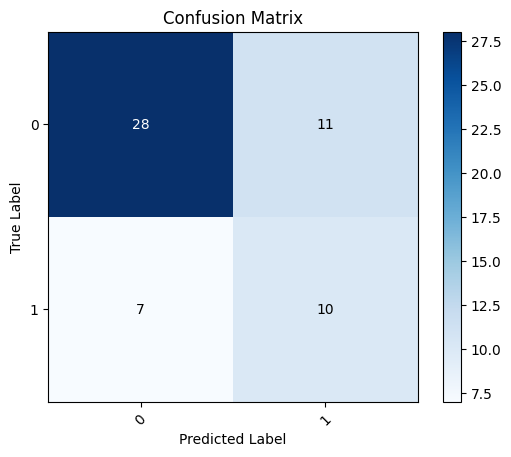

              precision    recall  f1-score   support

           0       0.80      0.72      0.76        39
           1       0.48      0.59      0.53        17

    accuracy                           0.68        56
   macro avg       0.64      0.65      0.64        56
weighted avg       0.70      0.68      0.69        56



In [32]:
label_file = test_label_file
true = label_file.to_numpy()[:, 2].flatten().tolist()
predicted = (np.array(test_preds) > 0.5).astype(np.int32).flatten().tolist()



true_labels = true
predicted_labels = predicted

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def create_confusion_matrix(true_labels, predicted_labels):
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)
    return cm

def plot_confusion_matrix(conf_matrix, classes):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def calculate_metrics(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return precision, recall, f1

conf_matrix = create_confusion_matrix(true_labels, predicted_labels)
classes = ['0', '1']

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, classes)

# Calculate precision, recall, and F1-score

# Calculate precision, recall, and F1-score for both classes
classification_report = classification_report(true_labels, predicted_labels, target_names=classes)

print(classification_report)